# Draw tree with tips having plots with enrichments of each mutation type

The following cell is tagged parameters, and will be replaced by the [papermill](https://papermill.readthedocs.io/en/latest/) parameters when the notebook is actually run:

In [1]:
treefile = "../results/clade_founder_tree/clade_founders.treefile"
rates_by_clade_csv = "../results/synonymous_mut_rates/rates_by_clade.csv"

Import Python modules:

In [61]:
import os

import ete3

import matplotlib

import numpy

import yaml

import pandas as pd

Read some information from configuration:

In [20]:
with open("config.yaml" if os.path.isfile("config.yaml") else "../config.yaml") as f:
    config = yaml.safe_load(f)
    
clade_synonyms = config["clade_synonyms"]

Read the rates by clade, and also get list of all clades we are using:

In [3]:
rates_by_clade = pd.read_csv(rates_by_clade_csv)

clades = sorted(rates_by_clade["clade"].unique())

Read the tree and do some formatting:

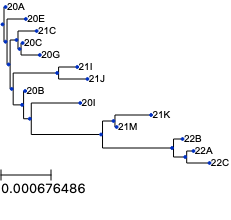

In [21]:
# read tree
with open(treefile) as f:
    newick_str = f.read()
t = ete3.Tree(newick_str)

# prune clades without rates
t.prune(clades, preserve_branch_length=True)

# set outgroup to first clade listed
t.set_outgroup(clades[0])

# ladderize the branches
t.ladderize()

t.render("%%inline")

Plot clade enrichments:

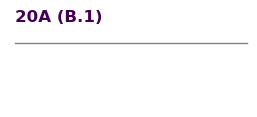

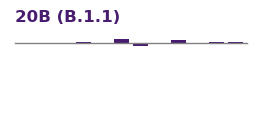

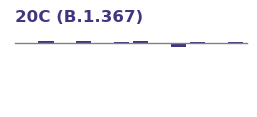

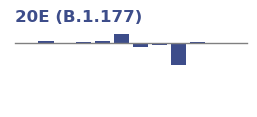

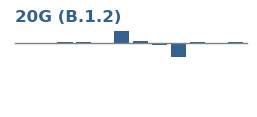

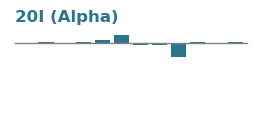

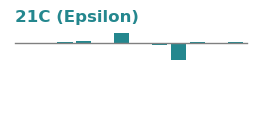

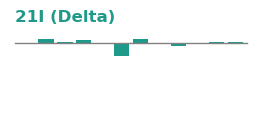

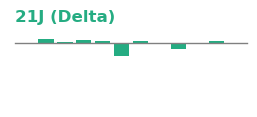

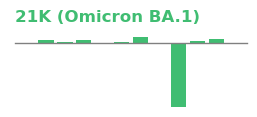

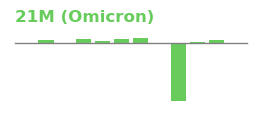

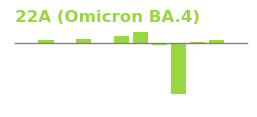

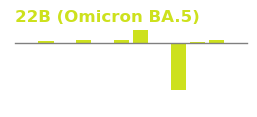

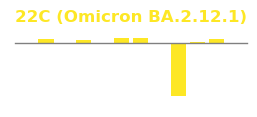

In [87]:
rates_fold_change = (
    rates_by_clade
    [["clade", "mut_type", "rate"]]
    .merge(
        rates_by_clade
        .query("clade == @clades[0]")
        [["mut_type", "rate"]]
        .rename(columns={"rate": "ref_rate"})
    )
    .assign(diff_rate=lambda x: x["rate"] - x["ref_rate"])
)

# colors
viridis = matplotlib.cm.get_cmap("viridis", len(clades))

for clade, clade_fold_change in rates_fold_change.groupby("clade"):
    color = viridis(clades.index(clade) / (len(clades) - 1))
    ax = clade_fold_change.plot(
        x="mut_type",
        y="diff_rate",
        kind="bar",
        legend=False,
        figsize=(3, 1),
        xticks=[],
        yticks=[],
        xlabel="",
        ylim=(
            rates_fold_change["diff_rate"].min(), rates_fold_change["diff_rate"].max(),
        ),
        width=0.8,
        color=color,
    )
    ax.spines["bottom"].set_position("zero")
    ax.spines["bottom"].set_color("gray")
    ax.spines["bottom"].set_linewidth(1)
    ax.spines["top"].set_color("none")
    ax.spines["right"].set_color("none")
    ax.spines["left"].set_color("none")
    ax.set_title(
        f"{clade} ({clade_synonyms[clade]})",
        fontdict={"color": color, "fontweight": "bold"},
        loc="left",
    )

In [75]:
ax.set_title?

Signature: ax.set_title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)
Docstring:
Set a title for the Axes.

Set one of the three available Axes titles. The available titles
are positioned above the Axes in the center, flush with the left
edge, and flush with the right edge.

Parameters
----------
label : str
    Text to use for the title

fontdict : dict
    A dictionary controlling the appearance of the title text,
    the default *fontdict* is::

       {'fontsize': rcParams['axes.titlesize'],
        'fontweight': rcParams['axes.titleweight'],
        'color': rcParams['axes.titlecolor'],
        'verticalalignment': 'baseline',
        'horizontalalignment': loc}

loc : {'center', 'left', 'right'}, default: :rc:`axes.titlelocation`
    Which title to set.

y : float, default: :rc:`axes.titley`
    Vertical Axes location for the title (1.0 is the top).  If
    None (the default) and :rc:`axes.titley` is also None, y is
    determined automatically to avoid decorator

In [72]:
?pd.DataFrame.plot

Init signature: pd.DataFrame.plot(data)
Docstring:     
Make plots of Series or DataFrame.

Uses the backend specified by the
option ``plotting.backend``. By default, matplotlib is used.

Parameters
----------
data : Series or DataFrame
    The object for which the method is called.
x : label or position, default None
    Only used if data is a DataFrame.
y : label, position or list of label, positions, default None
    Allows plotting of one column versus another. Only used if data is a
    DataFrame.
kind : str
    The kind of plot to produce:

    - 'line' : line plot (default)
    - 'bar' : vertical bar plot
    - 'barh' : horizontal bar plot
    - 'hist' : histogram
    - 'box' : boxplot
    - 'kde' : Kernel Density Estimation plot
    - 'density' : same as 'kde'
    - 'area' : area plot
    - 'pie' : pie plot
    - 'scatter' : scatter plot (DataFrame only)
    - 'hexbin' : hexbin plot (DataFrame only)
ax : matplotlib axes object, default None
    An axes of the current figure.
su